# Combine longer speaker diarization

Problem with unsupervised clustering speaker diarization technique, the longer audio you have, the more expensive to calculate, easily to hit out-of-memory issue.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/combine-longer-speaker-diarization](https://github.com/huseinzol05/malaya-speech/tree/master/example/combine-longer-speaker-diarization).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech
from malaya_speech import Pipeline
import matplotlib.pyplot as plt

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


### load Speaker Vector

In [3]:
model = malaya_speech.speaker_vector.nemo(model = 'huseinzol05/nemo-titanet_large')

In [4]:
_ = model.eval()

### Load audio sample

In [5]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y) / sr

102.1398125

### Split audio sample into multiple samples

In [6]:
ys = list(malaya_speech.utils.generator.frames(y, 60000, sr))
len(ys)

2

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [7]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

2023-02-19 19:26:00.569372: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 19:26:00.575818: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-19 19:26:00.575837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2023-02-19 19:26:00.575840: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2023-02-19 19:26:00.575899: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-02-19 19:26:00.575911: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported vers

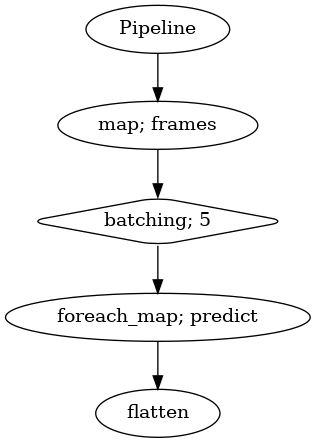

In [8]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.utils.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
    .batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

/home/husein/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=480
  warnings.warn(


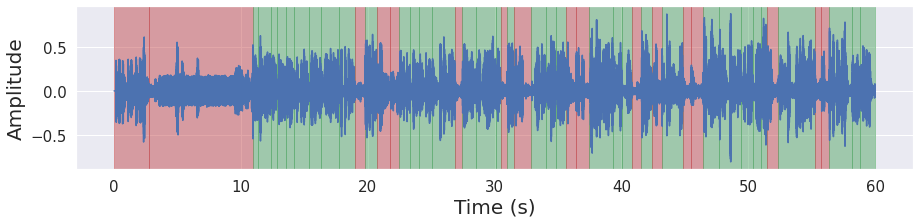

CPU times: user 47.7 s, sys: 3.49 s, total: 51.2 s
Wall time: 6.56 s


In [9]:
%%time

result = p(ys[0])
frames = result['frames']
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad_0 = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)
malaya_speech.extra.visualization.visualize_vad(ys[0], grouped_vad_0, sr, figsize = (15, 3))

/home/husein/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=480
  warnings.warn(
/home/husein/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=317
  warnings.warn(


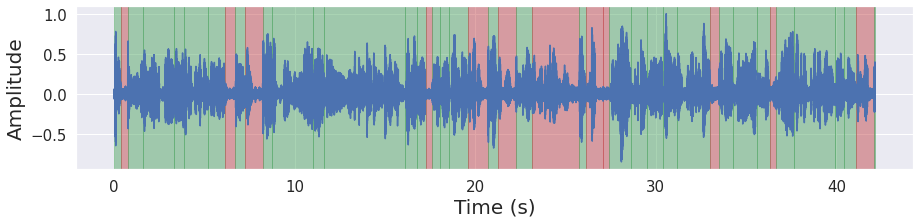

CPU times: user 32.9 s, sys: 1.44 s, total: 34.3 s
Wall time: 4.4 s


In [10]:
%%time

result = p(ys[1])
frames = result['frames']
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad_1 = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)
malaya_speech.extra.visualization.visualize_vad(ys[1], grouped_vad_1, sr, figsize = (15, 3))

### Load Hidden Markov model

Make sure you already installed `hmmlearn`, if not, simply,

```bash
pip3 install hmmlearn
```

```python
class HiddenMarkovModelClustering:
    def __init__(
        self,
        min_clusters: int,
        max_clusters: int,
        metric: str = 'cosine',
        covariance_type: str = 'diag',
        threshold: float = 0.35,
        single_cluster_detection_quantile: float = 0.05,
        single_cluster_detection_threshold: float = 1.15,
    ):
        """
        Load malaya-speech HiddenMarkovModel, originallly from pyannote, https://github.com/pyannote/pyannote-audio/blob/develop/pyannote/audio/pipelines/clustering.py

        Parameters
        ----------
        min_clusters: int
            minimum cluster size, must bigger than 0
        max_clusters: int
            maximum cluster size, must equal or bigger than `min_clusters`.
            if equal to `min_clusters`, will directly fit into HMM without calculating the best cluster size.
        metric: str, optional (default='cosine')
            Only support `cosine` and `euclidean`.
        covariance_type: str, optional (default='diag')
            Acceptable input shape, https://hmmlearn.readthedocs.io/en/latest/api.html#gaussianhmm
        threshold: float, optional (default=0.35)
            minimum threshold to assume current iteration of cluster is the best fit.
        """
```

To get better results using HMM, set `norm_function=None` and `log_distance_metric=None`.

In [11]:
from malaya_speech.model.clustering import HiddenMarkovModelClustering

In [12]:
hmm_model = HiddenMarkovModelClustering(min_clusters = 1, max_clusters = 5, threshold = 0.35)

In [13]:
result_diarization_0 = malaya_speech.diarization.clustering(
    vad_results = grouped_vad_0, 
    speaker_vector = model,
    model = hmm_model,
    norm_function = None,
)
result_diarization_0[:5]

[(<malaya_speech.model.frame.Frame at 0x7fc6102e5fa0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x7fc6102c9040>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x7fc6102c90a0>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x7fc6102c9100>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x7fc6102c9160>, 'speaker 3')]

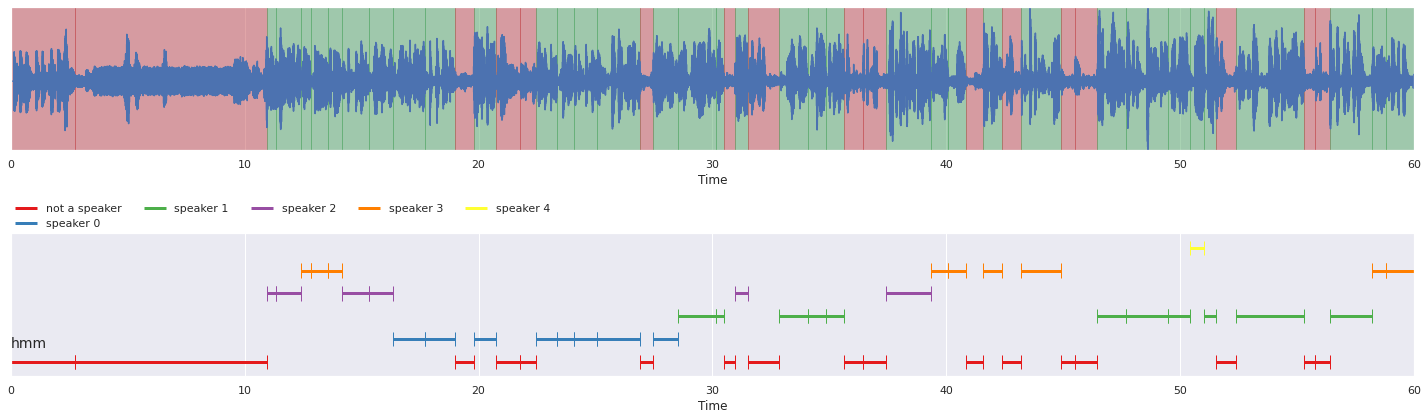

In [14]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(ys[0], grouped_vad_0, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_0, 
                                                      'hmm', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

In [16]:
result_diarization_1 = malaya_speech.diarization.clustering(
    vad_results = grouped_vad_1, 
    speaker_vector = model,
    model = hmm_model,
    norm_function = None,
)
result_diarization_1[:5]

[(<malaya_speech.model.frame.Frame at 0x7fc6201415e0>, 'speaker 4'),
 (<malaya_speech.model.frame.Frame at 0x7fc6200cc280>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x7fc6200cc2b0>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x7fc6200cc2e0>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x7fc629069400>, 'speaker 2')]

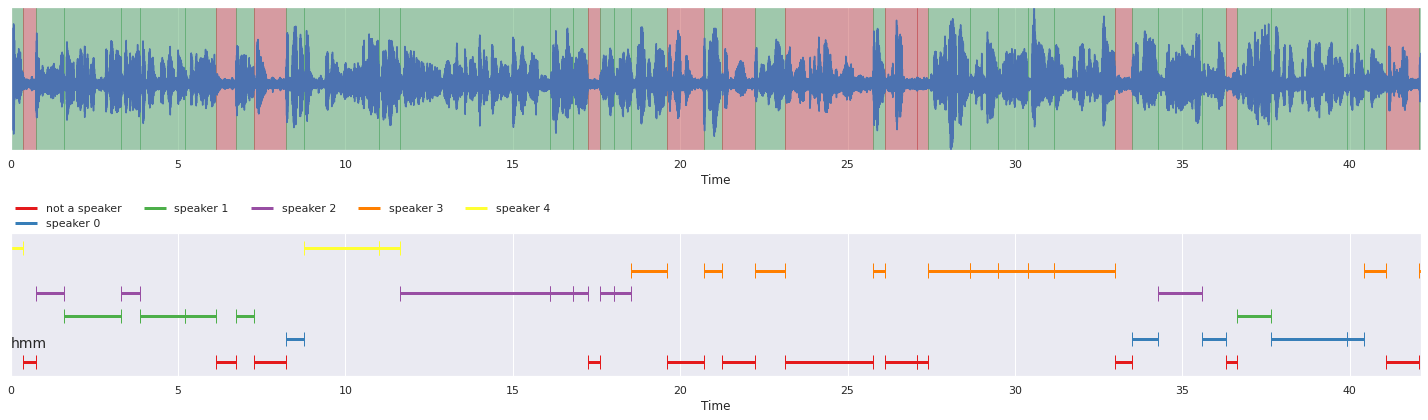

In [17]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(ys[1], grouped_vad_1, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_1, 
                                                      'hmm', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Combine multiple diarization results

```python
def combine(
    list_results,
    speaker_vector,
    similarity_threshold: float = 0.8,
    agg_function: Callable = np.mean,
):
    """
    Combined multiple diarization results into single diarization results using PageRank.
    Required malaya and networkx libraries.

    Parameters
    ----------
    vad_results: List[List[Tuple[Frame, label]]]
        results from multiple diarization results.
    speaker_vector: callable
        speaker vector object.
    similarity_threshold: float, optional (default=0.8)
        if current voice activity sample similar at least 0.8, we assumed it is from the existing speakers.
    agg_function: Callable, optional (default=np.mean)
        aggregate function to aggregate when we have multiple samples for the same speaker.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [26]:
%%time

combined = malaya_speech.diarization.combine([result_diarization_0, result_diarization_1],
                                                                 model, similarity_threshold = 0.7)

CPU times: user 21.8 s, sys: 153 ms, total: 22 s
Wall time: 1.86 s


In [27]:
combined[0]

(<malaya_speech.model.frame.Frame at 0x7fc7957dbd90>, 'not a speaker')

In [28]:
combined_vad = []
for c in combined:
    vad_label = c[1] != 'not a speaker'
    combined_vad.append((c[0], vad_label))

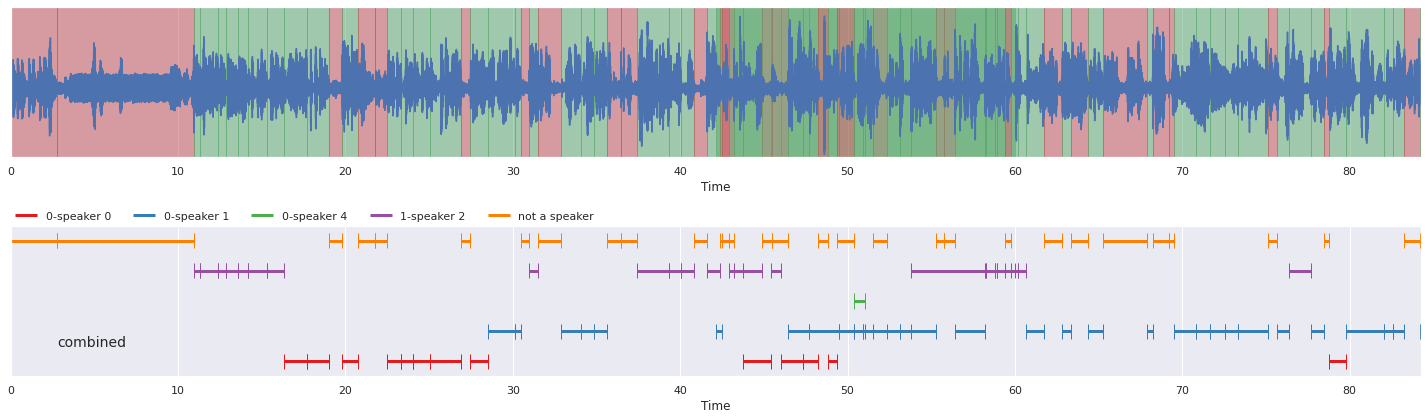

In [29]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, combined_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(combined, 
                                                      'combined', ax = ax[1],
                                                     x_text = 0.02)
fig.tight_layout()
plt.show()